# Mask R-CNN

This notebook shows how to train a Mask R-CNN object detection and segementation model on a custom coco-style data set.

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

sys.path.insert(0, '../libraries')
from mrcnn.config import Config
import mrcnn.utils as utils
import mrcnn.model as modellib
import mrcnn.visualize as visualize
from mrcnn.model import log
import mcoco.coco as coco
import mextra.utils as extra_utils

%matplotlib inline
%config IPCompleter.greedy=True

HOME_DIR = 'E:\Instance Segementation\Final_model\Model_dir'
DATA_DIR = os.path.join(HOME_DIR, "data/shapes")
WEIGHTS_DIR = os.path.join(HOME_DIR, "data/weights")
MODEL_DIR = os.path.join(DATA_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(WEIGHTS_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Dataset

Organize the dataset using the following structure:

```
DATA_DIR
│
└───annotations
│   │   instances_<subset><year>.json
│   
└───<subset><year>
    │   image021.jpeg
    │   image022.jpeg
```

In [ ]:
dataset_train = coco.CocoDataset()
dataset_train.load_coco(DATA_DIR, subset="shapes_train", year="2018")
dataset_train.prepare()

dataset_validate = coco.CocoDataset()
dataset_validate.load_coco(DATA_DIR, subset="shapes_validate", year="2018")
dataset_validate.prepare()

dataset_test = coco.CocoDataset()
dataset_test.load_coco(DATA_DIR, subset="shapes_test", year="2018")
dataset_test.prepare()

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    print(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Configuration

In [ ]:
image_size = 64
rpn_anchor_template = (1, 2, 4, 8, 16) # anchor sizes in pixels
rpn_anchor_scales = tuple(i * (image_size // 16) for i in rpn_anchor_template)

class ShapesConfig(Config):
    """Configuration for training on the shapes dataset.
    """
    NAME = "shapes"

    # Train on 1 GPU and 2 images per GPU. Put multiple images on each
    # GPU if the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 10  # background + 3 shapes (triangles, circles, and squares)

    # Use smaller images for faster training. 
    IMAGE_MAX_DIM = image_size
    IMAGE_MIN_DIM = image_size
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = rpn_anchor_scales

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    STEPS_PER_EPOCH = 10

    VALIDATION_STEPS = STEPS_PER_EPOCH / 20
    
config = ShapesConfig()
config.display()

# Model


In [ ]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [8]:
inititalize_weights_with = "last"  # imagenet, coco, or last

if inititalize_weights_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
    
elif inititalize_weights_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
    
elif inititalize_weights_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [8]:
import keras
import tensorflow as tf

In [9]:
print(keras.__version__)
print(tf.__version__)

2.2.4
1.14.0



# Training

Training in two stages

## Heads

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

In [29]:
# model.train(dataset_train, dataset_validate, 
#             learning_rate=config.LEARNING_RATE, 
#             epochs=2,
#             layers='heads')

## Fine-tuning

Fine-tune all layers. Pass layers="all to train all layers.

In [18]:
model.train(dataset_train, dataset_validate, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=0, # starts from the previous epoch, so only 1 additional is trained 
            layers="all")

AssertionError: Create model in training mode.

# Detection

In [7]:
MODEL_DIR

'E:\\Instance Segementation\\Final_model\\deep-learning-explorer\\data/shapes\\logs'

In [6]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
#Mask RCNN
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
print(model.find_last()[1])
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



W0319 15:12:11.733625 21868 module_wrapper.py:139] From C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0319 15:12:11.740607 21868 module_wrapper.py:139] From C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0319 15:12:11.744596 21868 module_wrapper.py:139] From C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0319 15:12:11.763582 21868 module_wrapper.py:139] From C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:2139: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W03

E:\Instance Segementation\Final_model\deep-learning-explorer\data/shapes\logs\shapes20200316T1634\mask_rcnn_shapes_0201.h5
Loading weights from  E:\Instance Segementation\Final_model\deep-learning-explorer\data/shapes\logs\shapes20200316T1634\mask_rcnn_shapes_0201.h5


W0319 15:12:16.067635 21868 module_wrapper.py:139] From C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0319 15:12:16.068593 21868 module_wrapper.py:139] From C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0319 15:12:16.068593 21868 module_wrapper.py:139] From C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0319 15:12:16.108489 21868 module_wrapper.py:139] From C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0319 15:1

### Test on a random image from the test set

First, show the ground truth of the image, then show detection results.

BG
0
original_image           shape: (64, 64, 3)           min:    0.00000  max:  232.00000  uint8
image_meta               shape: (23,)                 min:    0.00000  max: 3664.00000  float64
gt_class_id              shape: (10,)                 min:    1.00000  max:   10.00000  int32
gt_bbox                  shape: (10, 4)               min:    1.00000  max:   56.00000  int32
gt_mask                  shape: (64, 64, 10)          min:    0.00000  max:    1.00000  bool


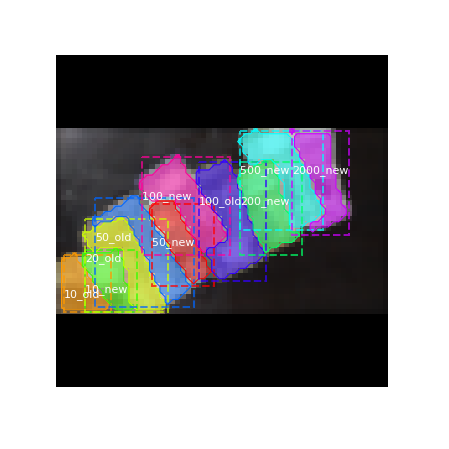

Here1
Processing 1 images
image                    shape: (64, 64, 3)           min:    0.00000  max:  232.00000  uint8
molded_images            shape: (1, 64, 64, 3)        min: -123.70000  max:  128.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:   64.00000  int32
anchors                  shape: (1, 1023, 4)          min:   -0.71833  max:    0.98140  float32

*** No instances to display *** 

class_ids []


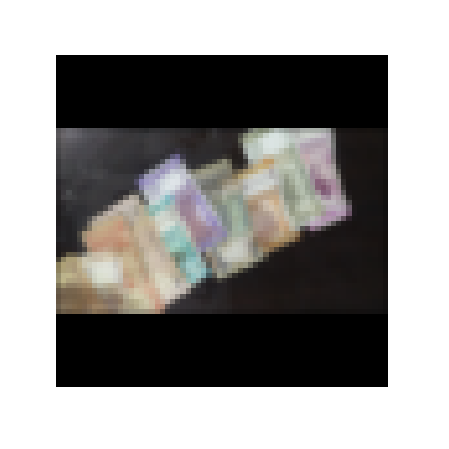

In [7]:
print(dataset_test.class_names[0])
image_id = random.choice(dataset_test.image_ids)
print(image_id)
for image_id in dataset_test.image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
      modellib.load_image_gt(dataset_test, inference_config, 
                             image_id, use_mini_mask=False)
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                              dataset_test.class_names, figsize=(8, 8))
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                              dataset_test.class_names, r['scores'], ax=get_ax())
print("class_ids {}".format(r['class_ids']))
detected = []
for cl in r['class_ids']:
    print(dataset_test.class_names[cl])
    detected.append(dataset_test.class_names[cl])
  # print(dataset_test.class_names[r['class_ids'][0]])


original_image           shape: (64, 64, 3)           min:    0.00000  max:  246.00000  uint8
image_meta               shape: (23,)                 min:    0.00000  max:  880.00000  float64
gt_class_id              shape: (1,)                  min:   10.00000  max:   10.00000  int32
gt_bbox                  shape: (1, 4)                min:    1.00000  max:   56.00000  int32
gt_mask                  shape: (36, 92, 1)           min:    0.00000  max:    1.00000  bool


ValueError: operands could not be broadcast together with shapes (36,92) (64,64) (64,64) 

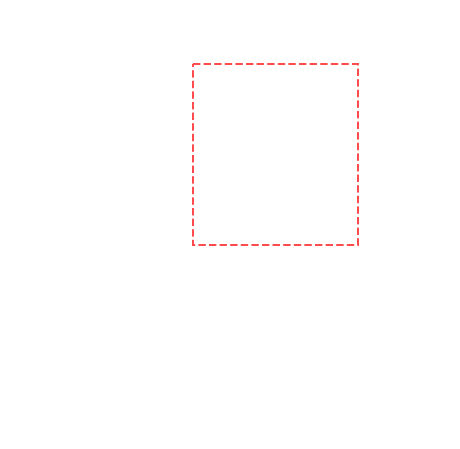

In [9]:
# import matplotlib as plt
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=get_ax())
# plt.savefig('out.png')

# Evaluation

Use the test dataset to evaluate the precision of the model on each class. 

In [14]:
predictions =\
extra_utils.compute_multiple_per_class_precision(model, inference_config, dataset_test,
                                                 number_of_images=250, iou_threshold=0.5)
complete_predictions = []

for shape in predictions:
    complete_predictions += predictions[shape]
    print("{} ({}): {}".format(shape, len(predictions[shape]), np.mean(predictions[shape])))

print("--------")
print("average: {}".format(np.mean(complete_predictions)))

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
print(model.find_last()[1])

## Convert result to COCO

Converting the result back to a COCO-style format for further processing 

In [ ]:
import json
import pylab
import matplotlib.pyplot as plt
from tempfile import NamedTemporaryFile
from pycocotools.coco import COCO

coco_dict = extra_utils.result_to_coco(results[0], dataset_test.class_names,
                                       np.shape(original_image)[0:2], tolerance=0)

with NamedTemporaryFile('w') as jsonfile:
    json.dump(coco_dict, jsonfile)
    jsonfile.flush()
    coco_data = COCO(jsonfile.name)

In [ ]:
category_ids = coco_data.getCatIds(catNms=['square', 'circle', 'triangle'])
image_data = coco_data.loadImgs(1)[0]
image = original_image
plt.imshow(image); plt.axis('off')
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
annotation_ids = coco_data.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)
annotations = coco_data.loadAnns(annotation_ids)
coco_data.showAnns(annotations)